In [52]:
import numpy as np
from sympy import ordered, Matrix, hessian, lambdify
from sympy.abc import x, y
import matplotlib.pyplot as plt

In [50]:
# use sympy to return a lambda function for the gradient and hessian of an equation
def compute_gradient_hessian(eq, *args):
    f = eq(*args)
    vars = list(ordered(f.free_symbols))

    gradient = lambda func, vars : Matrix([func]).jacobian(vars)

    grad_lambda = lambda x : lambdify(vars, gradient(f, vars))(*x).flatten()
    hess_lambda = lambda x : lambdify(vars, hessian(f, vars))(*x)

    return grad_lambda, hess_lambda

def quadratic_model(f_k, grad_k, hess_k):
    return lambda p : f_k + p.dot(grad_k) + 0.5 * p.dot(hess_k).dot(p)

# return the positive root of Tau using the quadratic formula
def find_tau(z_j, d_j, radius):
    a = z_j.dot(z_j)
    b = z_j.dot(d_j)
    c = d_j.dot(d_j)
    return (np.sqrt(c*(radius**2 - a) + b**2) - b) / c

# page 171 in Nocedal
# find Tau directly by using the quadratic formula
def steihaug(radius, grad_k, hess_k, eps=1e-8):
    z_j = np.zeros(grad_k.size)
    r_j = np.copy(grad_k)
    d_j = -np.copy(grad_k)

    if np.linalg.norm(grad_k) < eps:
        return z_j

    while True:
        dBd = d_j.dot(hess_k).dot(d_j)

        # Negative curvature condition
        if dBd <= 0:
            # return the intersection of the current direction with the trust-region boundary
            return z_j + find_tau(z_j, d_j, radius) * d_j

        alpha_j = (r_j.dot(r_j)) / dBd
        z_old = np.copy(z_j)
        z_j += alpha_j * d_j

        # Trust region condition
        if np.linalg.norm(z_j) >= radius:
            # return the intersection of the current direction with the trust-region boundary
            return z_j + find_tau(z_j, d_j, radius) * d_j

        r_old = np.copy(r_j)
        r_j += alpha_j * hess_k.dot(d_j)

        # Stopping condition
        if np.linalg.norm(r_j) < eps:
            return z_j

        beta_j = (r_j.dot(r_j)) / (r_old.dot(r_old))
        d_j = beta_j * d_j - r_j



# n must be between 0 and 0.25
# from Nocedal page 69
def trust_region(f, f_grad, f_hess, x_0, tol=1e-15, model=quadratic_model, radius_0=1.0, radius_max=300.0, n=1e-3):
    k = 0
    x_k = x_0
    radius = radius_0

    # evaluate function, gradient, hessian, and model function at x_k
    f_k = f(x_k)
    grad_k = f_grad(x_k)
    hess_k = f_hess(x_k)
    model_k = model(f_k, grad_k, hess_k)

    error = []
    error.append(np.linalg.norm(np.subtract(x_0, [1,1])))

    while np.linalg.norm(f_grad(x_k)) > tol:
        # solve subproblem using Steihaug's Method
        p_k = steihaug(radius, grad_k, hess_k)

        # evaluate agreement between model function and actual function
        rho_k = (f(x_k) - f(x_k + p_k)) / (f(x_k) - model_k(p_k))

        if rho_k < 0.25:
            # poor approximation so shrink the trust-radius
            radius = 0.25 * radius
        elif rho_k > 0.75 and np.abs(np.linalg.norm(p_k) - radius) < tol:
            # good approximation and a full-step (within tolerance) was taken, expand trust_radius
            radius = min(2 * radius, radius_max)
        # otherwise leave the radius unchanged

        # if approximation was good, update x to the new step. Otherwise leave x unchanged
        if rho_k > n:
            x_k = x_k + p_k

            # update function evaluation, gradient, hessian, and model function at x_k+1
            f_k = f(x_k)
            grad_k = f_grad(x_k)
            hess_k = f_hess(x_k)
            model_k = model(f_k, grad_k, hess_k)

        k += 1

        error.append(np.linalg.norm(np.subtract(x_k, [1, 1])))


        if np.linalg.norm(p_k) < tol:
            break

    return [x_k, k, error]


/var/folders/2m/pnw5mkds7jlbndvtgss60thc0000gn/T/ipykernel_98946/2940523574.py:83: RuntimeWarning: invalid value encountered in double_scalars
  rho_k = (f(x_k) - f(x_k + p_k)) / (f(x_k) - model_k(p_k))


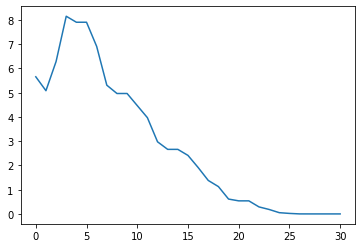

In [53]:
# Rosenbrock function
a = 1
b = 100
rosenbrock = lambda x : (a-x[0])**2 + b*(x[1]-x[0]**2)**2

rosen_grad, rosen_hess = compute_gradient_hessian(rosenbrock, [x, y])

res = trust_region(rosenbrock, rosen_grad, rosen_hess, [5, 5])

plt.plot(res[2])

#

In [54]:
res[0]

array([1., 1.])